In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4769 - acc: 0.2231
Epoch 00001: val_loss improved from inf to 2.30056, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_1_conv_checkpoint/001-2.3006.hdf5
36805/36805 [==============================] - 29s 777us/sample - loss: 2.4769 - acc: 0.2231 - val_loss: 2.3006 - val_acc: 0.2821
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0581 - acc: 0.3920
Epoch 00002: val_loss improved from 2.30056 to 2.17512, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_1_conv_checkpoint/002-2.1751.hdf5
36805/36805 [==============================] - 27s 724us/sample - loss: 2.0582 - acc: 0.3920 - val_loss: 2.1751 - val_acc: 0.3235
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7870 - acc: 0.4780
Epoch 00003: val_loss improved from 2.17512 to 2.13879, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.3351 - acc: 0.9164
Epoch 00028: val_loss did not improve from 2.12853
36805/36805 [==============================] - 26s 713us/sample - loss: 0.3351 - acc: 0.9163 - val_loss: 3.0473 - val_acc: 0.3329
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3190 - acc: 0.9189
Epoch 00029: val_loss did not improve from 2.12853
36805/36805 [==============================] - 26s 717us/sample - loss: 0.3190 - acc: 0.9190 - val_loss: 3.1002 - val_acc: 0.3371
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3062 - acc: 0.9230
Epoch 00030: val_loss did not improve from 2.12853
36805/36805 [==============================] - 26s 713us/sample - loss: 0.3062 - acc: 0.9230 - val_loss: 3.1438 - val_acc: 0.3382
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2901 - acc: 0.9267
Epoch 00031: val_loss did not improve from 2.12853
36805/36805 [==================

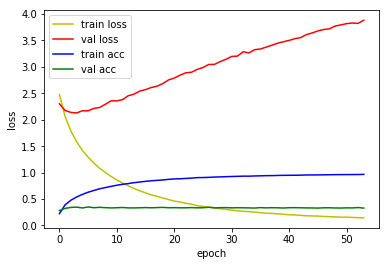

4815/4815 [==============================] - 1s 288us/sample - loss: 2.1545 - acc: 0.3225
Loss: 2.154451996168491 Accuracy: 0.32253376

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2736 - acc: 0.2959
Epoch 00001: val_loss improved from inf to 1.97886, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_2_conv_checkpoint/001-1.9789.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 2.2735 - acc: 0.2959 - val_loss: 1.9789 - val_acc: 0.4002
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8155 - acc: 0.4528
Epoch 00002: val_loss improved from 1.97886 to 1.80297, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_2_conv_checkpoint/002-1.8030.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.8157 - acc: 0.4528 - val_loss: 1.8030 - val_acc: 0.4386
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.2971 - acc: 0.9114
Epoch 00028: val_loss did not improve from 1.72297
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2971 - acc: 0.9114 - val_loss: 2.3612 - val_acc: 0.4808
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2836 - acc: 0.9143
Epoch 00029: val_loss did not improve from 1.72297
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2836 - acc: 0.9143 - val_loss: 2.4072 - val_acc: 0.4785
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2727 - acc: 0.9177
Epoch 00030: val_loss did not improve from 1.72297
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2727 - acc: 0.9177 - val_loss: 2.4254 - val_acc: 0.4831
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2622 - acc: 0.9211
Epoch 00031: val_loss did not improve from 1.72297
36805/36805 [========================

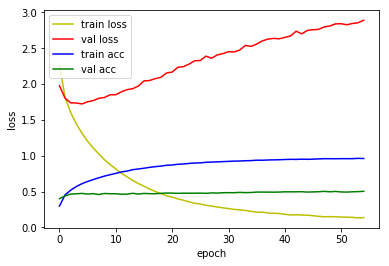

4815/4815 [==============================] - 2s 473us/sample - loss: 1.7904 - acc: 0.4538
Loss: 1.7904148946051037 Accuracy: 0.45379025

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2082 - acc: 0.3095
Epoch 00001: val_loss improved from inf to 1.78154, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_3_conv_checkpoint/001-1.7815.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.2082 - acc: 0.3095 - val_loss: 1.7815 - val_acc: 0.4542
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6315 - acc: 0.4962
Epoch 00002: val_loss improved from 1.78154 to 1.53582, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_3_conv_checkpoint/002-1.5358.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.6314 - acc: 0.4962 - val_loss: 1.5358 - val_acc: 0.5311
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8777
Epoch 00027: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3830 - acc: 0.8777 - val_loss: 1.4172 - val_acc: 0.6438
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3700 - acc: 0.8785
Epoch 00028: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3700 - acc: 0.8784 - val_loss: 1.4296 - val_acc: 0.6506
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3583 - acc: 0.8855
Epoch 00029: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3583 - acc: 0.8855 - val_loss: 1.4220 - val_acc: 0.6459
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3442 - acc: 0.8898
Epoch 00030: val_loss did not improve from 1.29989
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1806 - acc: 0.9413
Epoch 00057: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1806 - acc: 0.9413 - val_loss: 1.5393 - val_acc: 0.6741
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9427
Epoch 00058: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1758 - acc: 0.9427 - val_loss: 1.5680 - val_acc: 0.6720
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9438
Epoch 00059: val_loss did not improve from 1.29989
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1747 - acc: 0.9438 - val_loss: 1.5392 - val_acc: 0.6825
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1706 - acc: 0.9452
Epoch 00060: val_loss did not improve from 1.29989
36805/36805 [===========

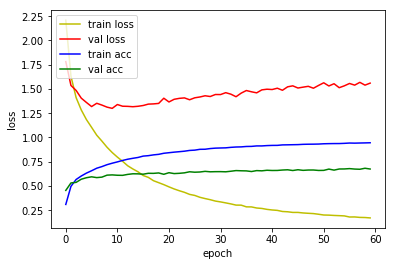

4815/4815 [==============================] - 3s 524us/sample - loss: 1.3719 - acc: 0.5796
Loss: 1.3718986924934982 Accuracy: 0.57964694

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2091 - acc: 0.2881
Epoch 00001: val_loss improved from inf to 1.67273, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_4_conv_checkpoint/001-1.6727.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.2090 - acc: 0.2882 - val_loss: 1.6727 - val_acc: 0.4812
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6237 - acc: 0.4785
Epoch 00002: val_loss improved from 1.67273 to 1.43742, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_4_conv_checkpoint/002-1.4374.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6239 - acc: 0.4785 - val_loss: 1.4374 - val_acc: 0.5663
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4762 - acc: 0.8496
Epoch 00024: val_loss did not improve from 0.82008
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4764 - acc: 0.8496 - val_loss: 0.8395 - val_acc: 0.7591
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4574 - acc: 0.8542
Epoch 00025: val_loss did not improve from 0.82008
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4574 - acc: 0.8542 - val_loss: 0.8647 - val_acc: 0.7563
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4413 - acc: 0.8580
Epoch 00026: val_loss did not improve from 0.82008
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4413 - acc: 0.8580 - val_loss: 0.8216 - val_acc: 0.7701
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4316 - acc: 0.8622
Epoch 00027: val_loss did not improve from 0.82008
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2549 - acc: 0.9153
Epoch 00053: val_loss did not improve from 0.80831
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2549 - acc: 0.9153 - val_loss: 0.8282 - val_acc: 0.7934
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2521 - acc: 0.9149
Epoch 00054: val_loss did not improve from 0.80831
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2521 - acc: 0.9149 - val_loss: 0.8542 - val_acc: 0.7943
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2476 - acc: 0.9180
Epoch 00055: val_loss did not improve from 0.80831
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2476 - acc: 0.9180 - val_loss: 0.8264 - val_acc: 0.8013
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.9169
Epoch 00056: val_loss did not improve from 0.80831
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1927 - acc: 0.9369
Epoch 00083: val_loss did not improve from 0.80831
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1927 - acc: 0.9369 - val_loss: 0.8753 - val_acc: 0.8062

1D_CNN_custom_DO_075_DO_4_conv Model


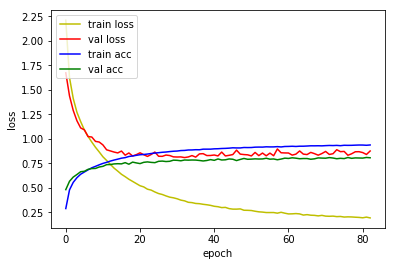

4815/4815 [==============================] - 3s 553us/sample - loss: 0.9202 - acc: 0.7502
Loss: 0.9201614695917408 Accuracy: 0.75015575

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2681 - acc: 0.2548
Epoch 00001: val_loss improved from inf to 1.69461, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_5_conv_checkpoint/001-1.6946.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.2680 - acc: 0.2548 - val_loss: 1.6946 - val_acc: 0.4512
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5905 - acc: 0.4902
Epoch 00002: val_loss improved from 1.69461 to 1.37278, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_5_conv_checkpoint/002-1.3728.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.5904 - acc: 0.4902 - val_loss: 1.3728 - val_acc: 0.5812
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4358 - acc: 0.8678
Epoch 00025: val_loss did not improve from 0.60161
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4357 - acc: 0.8678 - val_loss: 0.6056 - val_acc: 0.8290
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4233 - acc: 0.8690
Epoch 00026: val_loss improved from 0.60161 to 0.59118, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_5_conv_checkpoint/026-0.5912.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4233 - acc: 0.8690 - val_loss: 0.5912 - val_acc: 0.8400
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4153 - acc: 0.8715
Epoch 00027: val_loss did not improve from 0.59118
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4153 - acc: 0.8715 - val_loss: 0.6351 - val_acc: 0.8272
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2318 - acc: 0.9237
Epoch 00053: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2318 - acc: 0.9237 - val_loss: 0.5927 - val_acc: 0.8528
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2279 - acc: 0.9249
Epoch 00054: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2280 - acc: 0.9248 - val_loss: 0.5776 - val_acc: 0.8602
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2268 - acc: 0.9272
Epoch 00055: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2268 - acc: 0.9272 - val_loss: 0.5866 - val_acc: 0.8633
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2224 - acc: 0.9263
Epoch 00056: val_loss did not improve from 0.54927
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9461
Epoch 00083: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1672 - acc: 0.9461 - val_loss: 0.5677 - val_acc: 0.8721
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1612 - acc: 0.9468
Epoch 00084: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1612 - acc: 0.9469 - val_loss: 0.5804 - val_acc: 0.8728
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1592 - acc: 0.9486
Epoch 00085: val_loss did not improve from 0.54927
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1592 - acc: 0.9486 - val_loss: 0.5684 - val_acc: 0.8670
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1591 - acc: 0.9478
Epoch 00086: val_loss did not improve from 0.54927
36805/36805 [===========

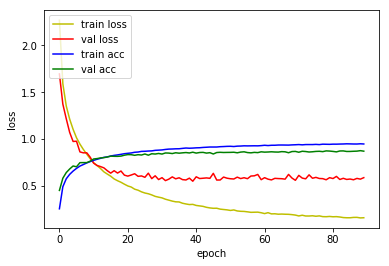

4815/4815 [==============================] - 3s 596us/sample - loss: 0.6525 - acc: 0.8204
Loss: 0.6524698791474197 Accuracy: 0.8203531

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3381 - acc: 0.2304
Epoch 00001: val_loss improved from inf to 1.67086, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_6_conv_checkpoint/001-1.6709.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.3380 - acc: 0.2305 - val_loss: 1.6709 - val_acc: 0.4836
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6529 - acc: 0.4554
Epoch 00002: val_loss improved from 1.67086 to 1.36520, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_6_conv_checkpoint/002-1.3652.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.6528 - acc: 0.4554 - val_loss: 1.3652 - val_acc: 0.5716
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4673 - acc: 0.8607
Epoch 00024: val_loss improved from 0.44933 to 0.44622, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_6_conv_checkpoint/024-0.4462.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4673 - acc: 0.8607 - val_loss: 0.4462 - val_acc: 0.8793
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4432 - acc: 0.8658
Epoch 00025: val_loss improved from 0.44622 to 0.40789, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_6_conv_checkpoint/025-0.4079.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4431 - acc: 0.8658 - val_loss: 0.4079 - val_acc: 0.8891
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4402 - acc: 0.8658
Epoch 00026: val_loss did not improve from 0.40789
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4402 - acc: 0.8659 - val_loss: 0.434

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2704 - acc: 0.9141
Epoch 00050: val_loss improved from 0.32963 to 0.32008, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_6_conv_checkpoint/050-0.3201.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2704 - acc: 0.9141 - val_loss: 0.3201 - val_acc: 0.9164
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9161
Epoch 00051: val_loss did not improve from 0.32008
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2681 - acc: 0.9161 - val_loss: 0.3248 - val_acc: 0.9157
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2609 - acc: 0.9170
Epoch 00052: val_loss did not improve from 0.32008
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2609 - acc: 0.9170 - val_loss: 0.3267 - val_acc: 0.9201
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9397
Epoch 00078: val_loss did not improve from 0.28977
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1857 - acc: 0.9397 - val_loss: 0.2924 - val_acc: 0.9192
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1813 - acc: 0.9420
Epoch 00079: val_loss did not improve from 0.28977
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1812 - acc: 0.9420 - val_loss: 0.3036 - val_acc: 0.9238
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1819 - acc: 0.9396
Epoch 00080: val_loss did not improve from 0.28977
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1819 - acc: 0.9396 - val_loss: 0.2906 - val_acc: 0.9241
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1794 - acc: 0.9407
Epoch 00081: val_loss did not improve from 0.28977
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9552
Epoch 00107: val_loss did not improve from 0.28724
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1376 - acc: 0.9552 - val_loss: 0.3122 - val_acc: 0.9301
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1394 - acc: 0.9539
Epoch 00108: val_loss did not improve from 0.28724
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1393 - acc: 0.9539 - val_loss: 0.3088 - val_acc: 0.9231
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1345 - acc: 0.9549
Epoch 00109: val_loss did not improve from 0.28724
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1345 - acc: 0.9550 - val_loss: 0.3020 - val_acc: 0.9313
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9566
Epoch 00110: val_loss did not improve from 0.28724
36805/36805 [=====================

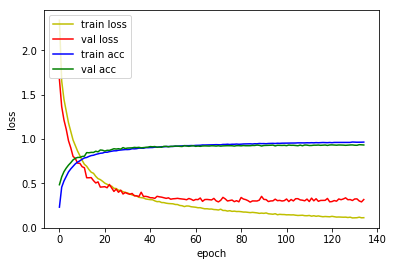

4815/4815 [==============================] - 3s 606us/sample - loss: 0.3323 - acc: 0.9084
Loss: 0.3323279743749157 Accuracy: 0.9084112

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5116 - acc: 0.1635
Epoch 00001: val_loss improved from inf to 1.85380, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_7_conv_checkpoint/001-1.8538.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.5115 - acc: 0.1636 - val_loss: 1.8538 - val_acc: 0.4372
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8019 - acc: 0.4051
Epoch 00002: val_loss improved from 1.85380 to 1.45698, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_7_conv_checkpoint/002-1.4570.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.8019 - acc: 0.4051 - val_loss: 1.4570 - val_acc: 0.5425
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3937 - acc: 0.8784
Epoch 00024: val_loss improved from 0.28651 to 0.26659, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_7_conv_checkpoint/024-0.2666.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3937 - acc: 0.8784 - val_loss: 0.2666 - val_acc: 0.9304
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3871 - acc: 0.8809
Epoch 00025: val_loss did not improve from 0.26659
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3872 - acc: 0.8809 - val_loss: 0.2706 - val_acc: 0.9273
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3791 - acc: 0.8796
Epoch 00026: val_loss improved from 0.26659 to 0.25356, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_7_conv_checkpoint/026-0.2536.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3791 - acc: 0.8797 - val_loss: 0.253

36800/36805 [============================>.] - ETA: 0s - loss: 0.2304 - acc: 0.9268
Epoch 00050: val_loss did not improve from 0.18789
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2304 - acc: 0.9268 - val_loss: 0.1984 - val_acc: 0.9469
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2260 - acc: 0.9277
Epoch 00051: val_loss did not improve from 0.18789
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2260 - acc: 0.9278 - val_loss: 0.1893 - val_acc: 0.9490
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2252 - acc: 0.9281
Epoch 00052: val_loss did not improve from 0.18789
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2251 - acc: 0.9281 - val_loss: 0.1926 - val_acc: 0.9504
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2167 - acc: 0.9286
Epoch 00053: val_loss did not improve from 0.18789
36805/36805 [========================

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9476
Epoch 00078: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1572 - acc: 0.9476 - val_loss: 0.1814 - val_acc: 0.9536
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9484
Epoch 00079: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1567 - acc: 0.9484 - val_loss: 0.1601 - val_acc: 0.9578
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1551 - acc: 0.9483
Epoch 00080: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1550 - acc: 0.9483 - val_loss: 0.1573 - val_acc: 0.9567
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1529 - acc: 0.9490
Epoch 00081: val_loss did not improve from 0.15158
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9618
Epoch 00108: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1107 - acc: 0.9617 - val_loss: 0.1610 - val_acc: 0.9602
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1078 - acc: 0.9638
Epoch 00109: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1079 - acc: 0.9638 - val_loss: 0.1704 - val_acc: 0.9576
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1099 - acc: 0.9631
Epoch 00110: val_loss did not improve from 0.15158
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1099 - acc: 0.9631 - val_loss: 0.1703 - val_acc: 0.9555
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1083 - acc: 0.9643
Epoch 00111: val_loss did not improve from 0.15158
36805/36805 [=======

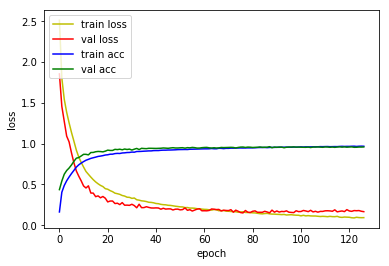

4815/4815 [==============================] - 3s 647us/sample - loss: 0.1840 - acc: 0.9448
Loss: 0.18403320234976825 Accuracy: 0.944756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5105 - acc: 0.1764
Epoch 00001: val_loss improved from inf to 1.82729, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_8_conv_checkpoint/001-1.8273.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 2.5104 - acc: 0.1764 - val_loss: 1.8273 - val_acc: 0.4500
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7312 - acc: 0.4327
Epoch 00002: val_loss improved from 1.82729 to 1.21631, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_8_conv_checkpoint/002-1.2163.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.7311 - acc: 0.4328 - val_loss: 1.2163 - val_acc: 0.6143
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2892 - acc: 0.9077
Epoch 00024: val_loss improved from 0.16712 to 0.15775, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_8_conv_checkpoint/024-0.1577.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2892 - acc: 0.9077 - val_loss: 0.1577 - val_acc: 0.9562
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.9126
Epoch 00025: val_loss did not improve from 0.15775
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2778 - acc: 0.9125 - val_loss: 0.1627 - val_acc: 0.9515
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.9146
Epoch 00026: val_loss did not improve from 0.15775
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2748 - acc: 0.9146 - val_loss: 0.1685 - val_acc: 0.9520
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1467 - acc: 0.9517
Epoch 00051: val_loss did not improve from 0.11001
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1468 - acc: 0.9517 - val_loss: 0.1121 - val_acc: 0.9665
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1460 - acc: 0.9536
Epoch 00052: val_loss did not improve from 0.11001
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1460 - acc: 0.9536 - val_loss: 0.1164 - val_acc: 0.9660
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9550
Epoch 00053: val_loss did not improve from 0.11001
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1393 - acc: 0.9550 - val_loss: 0.1149 - val_acc: 0.9653
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9545
Epoch 00054: val_loss did not improve from 0.11001
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0918 - acc: 0.9698
Epoch 00080: val_loss did not improve from 0.10123
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0918 - acc: 0.9698 - val_loss: 0.1096 - val_acc: 0.9704
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0864 - acc: 0.9705
Epoch 00081: val_loss did not improve from 0.10123
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0863 - acc: 0.9705 - val_loss: 0.1097 - val_acc: 0.9688
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9699
Epoch 00082: val_loss did not improve from 0.10123
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0879 - acc: 0.9699 - val_loss: 0.1042 - val_acc: 0.9706
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9703
Epoch 00083: val_loss improved from 0.10123 to 0.09683, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9787
Epoch 00109: val_loss did not improve from 0.09683
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0634 - acc: 0.9787 - val_loss: 0.1255 - val_acc: 0.9702
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9789
Epoch 00110: val_loss did not improve from 0.09683
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0619 - acc: 0.9789 - val_loss: 0.1179 - val_acc: 0.9711
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9812
Epoch 00111: val_loss did not improve from 0.09683
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0553 - acc: 0.9812 - val_loss: 0.1175 - val_acc: 0.9709
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9813
Epoch 00112: val_loss did not improve from 0.09683
36805/36805 [=====================

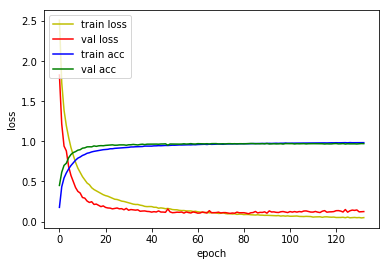

4815/4815 [==============================] - 3s 650us/sample - loss: 0.1450 - acc: 0.9574
Loss: 0.14504509495642823 Accuracy: 0.9574247

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2380 - acc: 0.2691
Epoch 00001: val_loss improved from inf to 1.35140, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_9_conv_checkpoint/001-1.3514.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.2379 - acc: 0.2691 - val_loss: 1.3514 - val_acc: 0.5772
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3399 - acc: 0.5584
Epoch 00002: val_loss improved from 1.35140 to 0.85749, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_9_conv_checkpoint/002-0.8575.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.3399 - acc: 0.5583 - val_loss: 0.8575 - val_acc: 0.7314
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1806 - acc: 0.9418
Epoch 00024: val_loss improved from 0.13549 to 0.13007, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_9_conv_checkpoint/024-0.1301.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1806 - acc: 0.9419 - val_loss: 0.1301 - val_acc: 0.9618
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9445
Epoch 00025: val_loss did not improve from 0.13007
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1749 - acc: 0.9445 - val_loss: 0.1400 - val_acc: 0.9567
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9459
Epoch 00026: val_loss did not improve from 0.13007
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1671 - acc: 0.9459 - val_loss: 0.1339 - val_acc: 0.9616
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9780
Epoch 00052: val_loss did not improve from 0.10869
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0671 - acc: 0.9780 - val_loss: 0.1290 - val_acc: 0.9660
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9765
Epoch 00053: val_loss did not improve from 0.10869
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0694 - acc: 0.9766 - val_loss: 0.1313 - val_acc: 0.9662
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9774
Epoch 00054: val_loss did not improve from 0.10869
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0654 - acc: 0.9774 - val_loss: 0.1196 - val_acc: 0.9667
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9785
Epoch 00055: val_loss did not improve from 0.10869
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9872
Epoch 00082: val_loss did not improve from 0.10869
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0367 - acc: 0.9872 - val_loss: 0.1487 - val_acc: 0.9704
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9879
Epoch 00083: val_loss did not improve from 0.10869
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0358 - acc: 0.9879 - val_loss: 0.1431 - val_acc: 0.9700
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9889
Epoch 00084: val_loss did not improve from 0.10869
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0328 - acc: 0.9889 - val_loss: 0.1339 - val_acc: 0.9697
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9886
Epoch 00085: val_loss did not improve from 0.10869
36805/36805 [===========

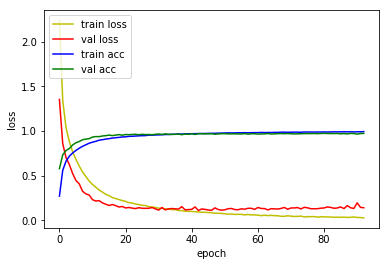

4815/4815 [==============================] - 3s 686us/sample - loss: 0.1667 - acc: 0.9529
Loss: 0.16666763805371332 Accuracy: 0.95285565



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 401us/sample - loss: 2.1545 - acc: 0.3225
Lo

4815/4815 [==============================] - 3s 686us/sample - loss: 0.6525 - acc: 0.8204
Loss: 0.6524698791474197 Accuracy: 0.8203531

1D_CNN_custom_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None,

4815/4815 [==============================] - 4s 745us/sample - loss: 0.1450 - acc: 0.9574
Loss: 0.14504509495642823 Accuracy: 0.9574247

1D_CNN_custom_DO_075_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None